# Preamble

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
import pickle

from multiprocessing import Pool 
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tqdm import tqdm_notebook as tqdm


import integrals as integ
import diff_eq_multi_2 as diff_eq
import physics as phys

# Load the standard solution.
a = pickle.load(open('../data/std_soln_He.p','rb'))

std_Tm = interp1d(a[0,:], a[1,:])
std_xH = interp1d(a[0,:], a[2,:])

# Constraints on $Q_\mathrm{eff}$

In [4]:
def max_Q_d_eff(m_m, m_C, f, Q):
    '''
    Constraints on Q_eff from self-interaction, CMB and tight coupling. Q_eff 
    is defined by Q_eff^4 = alpha_C*alpha_m / alpha_EM^2
    '''
    g_em    = np.sqrt(4*np.pi*phys.alpha)
    mu_pC   = m_C*phys.mp/(m_C + phys.mp)
    f_ratio = 1. + phys.omega_baryon/(f*phys.omega_DM)
    
    max_SI             = 0.26*(m_C/1e9)**(3/8) * np.sqrt(np.sqrt(4*np.pi)/g_em)
    max_CMB            = 1e-3 * np.sqrt(m_C/1e9) * np.sqrt(m_m/1e9) * (1e9/(m_m + m_C))**0.25 * f_ratio**0.25
    max_tight_coupling = 0.08 * np.sqrt(Q) * np.sqrt(m_C/1e8) * (1e9/m_m)**0.25
    
    return np.min((max_SI, max_CMB, max_tight_coupling))

# Function for Solving ODE

In [5]:
 def solve_ODE(params):
    '''
    Sets up the ODE with parameters given in params. 
    '''
        
    _m_m      = params[0]
    _m_C      = params[1]
    _f        = params[2]
    _Q        = params[3]
    _rtol     = params[4]
    _max_step = params[5] 
    
    # Fine the maximum Q_d,eff from the input parameters. 
    _Q_d_eff = max_Q_d_eff(_m_m, _m_C, _f, _Q)

    def to_integrate(rs, var):

        # Decide whether to include neutrals.
        neutral_H  = True
        neutral_He = True

        # Gets the function that returns all the derivatives. 
        # Last option here is whether to integrate with log_T_C or not.
        return diff_eq.DM_baryon_ODE(
            rs, var,
            _m_m, _m_C, _Q, _Q_d_eff, neutral_H, neutral_He, _f, True
        )

    # Number of attempts before giving up. 
    N_attempts = 0
    # Flag to determine if solution was reached.
    solved     = False

    # List of indices (m_m, Q) where the solution failed. 
    error_arr = [] 

    while (not solved) and (N_attempts < 3):
        # Keep attempting until solved or we've tried twice. 

        try:

            N_attempts += 1

            # Solve using solve_ivp. 
            soln = solve_ivp(
                to_integrate, [rs_vec[0], rs_vec[-1]], init_cond, 
                method='BDF', t_eval=rs_vec, 
                rtol=_rtol, max_step=_max_step
            )

        except:
            # solve_ivp returned an error. Adjust the tolerance
            # and step size and try again. 

            _rtol /= 1.2
            _max_step /= 1.5

        else:
            # solve_ivp completed successfully. However, we still need to check
            # that the solution managed to integrate over the entire redshift range,
            # and that there are no NaNs in the solution.
            if soln['t'].size == rs_vec.size and not np.isnan(soln['y']).any():

                solved = True

    if not solved:
        # If solution fails, simply return False. 
        soln = False

    return soln 

# Fixed Parameters

In [6]:
rs_start = 4000
rs_vec   = np.flipud(np.arange(10., rs_start, 1))

# Fixed Parameters
f   = 1e-4
m_C = 1e8   

# Loop Points
m_m_arr = 10**np.arange(6.2, 13.2, 0.2)
Q_arr   = 10**np.arange(-6.,  0.2, 0.2) # 31 entries

# Loop

In [ ]:
soln_arr  = np.zeros((m_m_arr.size, Q_arr.size, rs_vec.size, 6))

error_arr = []

for i,m_m in enumerate(tqdm(m_m_arr)):
    
    # Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
#     init_cond = [1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(1e-16), 1.] 
    init_cond = [1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(29e5/phys.c), 1.] 
    
    # List of parameters that need to be passed. 
    params = zip(
        m_m*np.ones_like(Q_arr) , m_C*np.ones_like(Q_arr),
        f*np.ones_like(Q_arr)   , Q_arr,
        1e-4*np.ones_like(Q_arr), np.inf*np.ones_like(Q_arr) 
    )
    
    
    # Parallelization.
    pool = Pool(Q_arr.size)
    
    soln_raw_arr = list(tqdm(pool.imap(solve_ODE, params)))
    
    for j,soln_raw in enumerate(soln_raw_arr): 
    
        if soln_raw:

            soln = np.transpose(soln_raw['y'])
            
            soln_arr[i,j] = soln

            # Convert to (T_b, T_m, T_C, V_bm, V_mC)
            soln_arr[i,j,:,0] = phys.TCMB(rs_vec) - soln_arr[i,j,:,0]
            soln_arr[i,j,:,1] = soln_arr[i,j,:,0] - soln_arr[i,j,:,1]
            soln_arr[i,j,:,2] = np.exp(soln_arr[i,j,:,2])
            soln_arr[i,j,:,3] = np.exp(soln_arr[i,j,:,3])
            soln_arr[i,j,:,4] = np.exp(soln_arr[i,j,:,4])

        else:
        
            # False was returned, and the solution failed. Append the index
            # to error_arr.
            error_arr.append([i,j])
            
    print('Errors: ', error_arr)
        

In [8]:
# pickle.dump((soln_arr, error_arr), open('/tigress/hongwanl/millicharged_DM_with_bath/data.p','wb'))

soln_arr, error_arr = pickle.load(open('/tigress/hongwanl/millicharged_DM_with_bath/data.p','rb'))

    

# Handling Problematic Points

In [66]:
print('Number of problematic points: ', len(error_arr))

# Pull the list of m_m and Q that need to be iterated over from error_arr.
m_m_err_arr = np.array([m_m_arr[pt[0]] for pt in error_arr])
Q_err_arr   = np.array([Q_arr[pt[1]] for pt in error_arr])

# Keeps track of which points become solved after running this cell.
solved_arr  = [False for _ in error_arr]

# Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
# init_cond = [2e-2, 2e-2, np.log(3e-4), np.log(1e-16), np.log(1e-16), 1.] 
init_cond = [1e-2, 1e-2, np.log(1e-5), np.log(1e-16), np.log(29e5/phys.c), 1.] 

# Strategies: adjust step-size, initial conditions

# New set of parameters for solution, pulled from the indices of error_arr. 
# Added helper indices in front to be accessed later.
params_full = np.transpose([
    np.arange(len(error_arr)),
    [err_ind[0] for err_ind in error_arr],
    [err_ind[1] for err_ind in error_arr],
    m_m_err_arr                   , m_C*np.ones_like(m_m_err_arr),
    f*np.ones_like(m_m_err_arr)   , Q_err_arr,
    8e-5*np.ones_like(m_m_err_arr), np.inf*np.ones_like(m_m_err_arr) 
])

# Split the parameters into chunks that can be fed into each thread. 
# There are Q_arr.size threads.
param_chunks = np.array_split(params_full, m_m_err_arr.size//Q_arr.size + 1)

for params in tqdm(param_chunks):
    
    # Parallelization.
    pool = Pool(Q_arr.size)

    soln_raw_arr = list(tqdm(pool.imap(solve_ODE, params[:,3:])))

    for err_ind,i,j,soln_raw in zip(
        params[:,0].astype(int), 
        params[:,1].astype(int), params[:,2].astype(int), soln_raw_arr
    ): 

        if soln_raw:
            # Solution was achieved.

            soln = np.transpose(soln_raw['y'])

            soln_arr[i,j] = soln

            # Convert to (T_b, T_m, T_C, V_bm, V_mC)
            soln_arr[i,j,:,0] = phys.TCMB(rs_vec) - soln_arr[i,j,:,0]
            soln_arr[i,j,:,1] = soln_arr[i,j,:,0] - soln_arr[i,j,:,1]
            soln_arr[i,j,:,2] = np.exp(soln_arr[i,j,:,2])
            soln_arr[i,j,:,3] = np.exp(soln_arr[i,j,:,3])
            soln_arr[i,j,:,4] = np.exp(soln_arr[i,j,:,4])

            print('Solved: [', i, ', ', j, ']')
            
            # Set the solved_arr at the appropriate index to True.
            solved_arr[err_ind] = True

# Produce a new error_arr, with entries in solved_arr that are True removed.
error_arr = [ind for solved,ind in zip(solved_arr,error_arr) if not solved]

print(error_arr)

pickle.dump((soln_arr, error_arr), open('/tigress/hongwanl/millicharged_DM_with_bath/data.p','wb'))

# REPEAT THIS CELL AS MANY TIMES AS NECESSARY TO REMOVE ALL PROBLEMATIC POINTS.


Number of problematic points:  12


../integrals.py:232: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(4*np.pi*ne_eV_cubed*ele_squared/T_m)
../integrals.py:232: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(4*np.pi*ne_eV_cubed*ele_squared/T_m)
../integrals.py:232: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(4*np.pi*ne_eV_cubed*ele_squared/T_m)
../integrals.py:232: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(4*np.pi*ne_eV_cubed*ele_squared/T_m)
../integrals.py:232: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(4*np.pi*ne_eV_cubed*ele_squared/T_m)
../integrals.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(4*np.pi*n_eV_cubed*ele_squared/T_zeta)
../diff_eq_multi_2.py:540: RuntimeWarning: divide by zero encountered in true_divide
  ) / time_fac(rs) / T_C
../integrals.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(4*np.pi*n_eV_cubed*ele_squar

Solved: [ 1 ,  5 ]
Solved: [ 1 ,  6 ]
Solved: [ 1 ,  7 ]
Solved: [ 1 ,  8 ]
Solved: [ 2 ,  5 ]
Solved: [ 2 ,  6 ]
Solved: [ 2 ,  7 ]
Solved: [ 2 ,  8 ]
Solved: [ 3 ,  5 ]
Solved: [ 3 ,  6 ]
Solved: [ 3 ,  7 ]
Solved: [ 3 ,  8 ]

[]


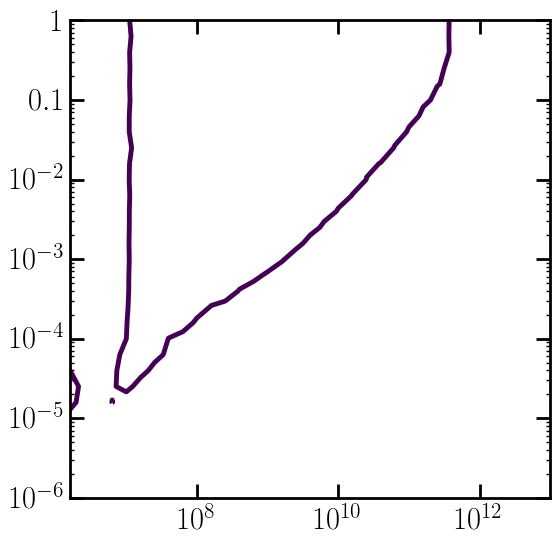

In [67]:
plt.figure()

plt.loglog()

plt.contour(m_m_arr, Q_arr, np.transpose(soln_arr[:,:,-8,0]/phys.kB), levels=[5.1])

In [24]:
pickle.dump((m_m_arr, Q_arr, rs_vec, soln_arr), open('/tigress/hongwanl/millicharged_DM_with_bath/f_1e-4_m_C_1e8_Vrel_29e5.p','wb'))



In [ ]:
m_m_err_arr = np.array([m_m_arr[pt[0]] for pt in error_arr])
Q_err_arr   = np.array([Q_arr[pt[1]] for pt in error_arr])
m_m_err_arr.size//Q_arr.size

In [ ]:
print(m_m_err_arr.size)
print(Q_arr.size)

In [65]:
print(Q_arr[5:7])
print(m_m_arr[1:4])

error_arr = [[1, 5], [1, 6], [1,7], [1,8], [2, 5], [2, 6], [2, 7], [2,8], [3, 5], [3, 6], [3, 7], [3,8]]

[1.00000000e-05 1.58489319e-05]
[2511886.43150958 3981071.70553498 6309573.44480194]


In [30]:
Q_ind_rerun = np.arange(24, 31)
error_arr = []
for i in np.arange(m_m_arr.size):
    for j in Q_ind_rerun:
        error_arr.append([i,j])

In [31]:
error_arr

[[0, 24],
 [0, 25],
 [0, 26],
 [0, 27],
 [0, 28],
 [0, 29],
 [0, 30],
 [1, 24],
 [1, 25],
 [1, 26],
 [1, 27],
 [1, 28],
 [1, 29],
 [1, 30],
 [2, 24],
 [2, 25],
 [2, 26],
 [2, 27],
 [2, 28],
 [2, 29],
 [2, 30],
 [3, 24],
 [3, 25],
 [3, 26],
 [3, 27],
 [3, 28],
 [3, 29],
 [3, 30],
 [4, 24],
 [4, 25],
 [4, 26],
 [4, 27],
 [4, 28],
 [4, 29],
 [4, 30],
 [5, 24],
 [5, 25],
 [5, 26],
 [5, 27],
 [5, 28],
 [5, 29],
 [5, 30],
 [6, 24],
 [6, 25],
 [6, 26],
 [6, 27],
 [6, 28],
 [6, 29],
 [6, 30],
 [7, 24],
 [7, 25],
 [7, 26],
 [7, 27],
 [7, 28],
 [7, 29],
 [7, 30],
 [8, 24],
 [8, 25],
 [8, 26],
 [8, 27],
 [8, 28],
 [8, 29],
 [8, 30],
 [9, 24],
 [9, 25],
 [9, 26],
 [9, 27],
 [9, 28],
 [9, 29],
 [9, 30],
 [10, 24],
 [10, 25],
 [10, 26],
 [10, 27],
 [10, 28],
 [10, 29],
 [10, 30],
 [11, 24],
 [11, 25],
 [11, 26],
 [11, 27],
 [11, 28],
 [11, 29],
 [11, 30],
 [12, 24],
 [12, 25],
 [12, 26],
 [12, 27],
 [12, 28],
 [12, 29],
 [12, 30],
 [13, 24],
 [13, 25],
 [13, 26],
 [13, 27],
 [13, 28],
 [13, 29],
 [1